# NAML project - Stroke prediction
###  Cavallini - Eusebio

Importing libraries.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Loading The Dataset.

In this section, we load the dataset.

In [4]:
# Loading the stroke risk analysis dataset from a CSV file and stores it in a Pandas DataFrame called 'df'.
df = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [5]:
# Renaming the columns of the DataFrame 'df' using a predefined list of new column names.
new_cols = ["id", "gender", "age", "hypertension", "heart-disease", "ever-married", "work-type", "Residence-type", "avg-glucose-level", "bmi", "smoking-status", "stroke"]

# Defining the features of the dataset by categorizing them into three lists:
# - 'cathegorical_features' for categorical variables,
# - 'binary_features' for binary variables,
# - 'numerical_features' for continuous numerical variables.
cathegorical_features = ['work-type', 'smoking-status']
binary_features = ['hypertension', 'heart-disease', 'gender', 'ever-married', 'Residence-type']
numerical_features = ['age', 'avg-glucose-level', 'bmi']

df.columns = new_cols

In [6]:
df.head()

,id,gender,age,hypertension,heart-disease,ever-married,work-type,Residence-type,avg-glucose-level,bmi,smoking-status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [7]:
# Removing the 'id' column from the DataFrame 'df' as it is not useful for the analysis.
df.drop('id', axis=1, inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart-disease      5110 non-null   int64  
 4   ever-married       5110 non-null   object 
 5   work-type          5110 non-null   object 
 6   Residence-type     5110 non-null   object 
 7   avg-glucose-level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking-status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


# Exploratory Data Analysis

## Data Pre-Processing

The first step we do in the pre-processing phase is to check for any missing values.

In [9]:
# Checkig for missing values in the DataFrame by counting the number of NaN (Not a Number) values in each column.
# This helps in identifying any data quality issues that need to be addressed.
df.isna().sum()

,0
gender,0
age,0
hypertension,0
heart-disease,0
ever-married,0
work-type,0
Residence-type,0
avg-glucose-level,0
bmi,201
smoking-status,0


In [10]:
df.isnull().sum()

,0
gender,0
age,0
hypertension,0
heart-disease,0
ever-married,0
work-type,0
Residence-type,0
avg-glucose-level,0
bmi,201
smoking-status,0


As we can clearly see, the BMI column presents some null values that we want to handle to guarantee data quality.

In [11]:
# Filters the DataFrame 'df' to include only rows where the 'bmi' column has missing values.
# Then, it counts the number of occurrences of each unique value in the 'stroke' column within these filtered rows.
bmi_strokes = df[df['bmi'].isnull()]['stroke'].value_counts()
# Counts the number of occurrences of each unique value in the 'stroke' column across the entire DataFrame.
stroke_count = df['stroke'].value_counts()
# Prints the counts of stroke occurrences for rows with missing 'bmi' values.
print(bmi_strokes)

stroke
0    161
1     40
Name: count, dtype: int64


In [12]:
# Calculates the percentage of missing 'bmi' values that are associated with stroke cases.
print("Percent of null values accounting for strokes ", 100*bmi_strokes[1]/stroke_count[1])

Percent of null values accounting for strokes  16.06425702811245


Observing these results, it’s clear that a significant percentage of participants who have experienced a stroke also have missing values in the BMI column. Therefore, it's important to be careful when handling these missing values to avoid introducing bias or losing valuable information.

Since in the paper is clearly stated that only the participants above 18 years old were considered, we proceed to remove the patients below 18 years old.

In [13]:
# Filtering the DataFrame to include only rows where the 'age' column is 18 or older.
df = df[df['age'] >= 18]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4254 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4254 non-null   object 
 1   age                4254 non-null   float64
 2   hypertension       4254 non-null   int64  
 3   heart-disease      4254 non-null   int64  
 4   ever-married       4254 non-null   object 
 5   work-type          4254 non-null   object 
 6   Residence-type     4254 non-null   object 
 7   avg-glucose-level  4254 non-null   float64
 8   bmi                4073 non-null   float64
 9   smoking-status     4254 non-null   object 
 10  stroke             4254 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 398.8+ KB


The dataset contains a relatively small number of stroke cases, and the missing BMI values represent 16% of these occurrences. Given this, we have chosen not to drop the missing values in the BMI column. Instead, we'll fill them with the column's mean to preserve as much information as possible.
In the other notebook, we opted to remove all samples with missing values in the BMI column instead of filling them in.

In [14]:
# Fill missing values in the 'bmi' column with the mean of the column to avoid losing data.
df['bmi'].fillna(df['bmi'].mean(), inplace=True)

In [15]:
# Display the count of unique values in the 'smoking-status' column
df['smoking-status'].value_counts()

,count
smoking-status,
never smoked,1752
Unknown,862
formerly smoked,860
smokes,780


In [16]:
# Counts the number of stroke cases where the 'smoking-status' is recorded as 'Unknown'.
unknown_smokers_stroke = df[(df['smoking-status'] == 'Unknown') & (df['stroke'] == 1)].shape[0]
# Counts the total number of stroke cases in the dataset.
stroke_count = df[df['stroke'] == 1].shape[0]

In [17]:
# Print the percentage of people with an unknown smoking status who had a stroke
print(f"Number of unknown smoking status people who had a stroke: {unknown_smokers_stroke/stroke_count*100:.2f}%")

Number of unknown smoking status people who had a stroke: 18.22%


Since participants with a stroke and an 'Unknown' category in the smoking-status represent 18.22% of stroke cases, dropping this category, as done in the referenced paper, may result in a significant loss of information. To address this, we opted to retain the data and use a RandomForestClassifier to predict the missing values in the smoking-status column. The other available columns will serve as features to predict these missing values.

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder

# Separate the data into known and unknown smoking-status groups
df_known = df[df['smoking-status'] != 'Unknown'].drop('stroke', axis=1) # Data with known smoking status
df_unknown = df[df['smoking-status'] == 'Unknown'].drop('stroke', axis=1) # Data with unknown smoking status

# Prepare the features and target for training
X_known = df_known.drop('smoking-status', axis=1)  # Features (excluding smoking-status)
y_known = df_known['smoking-status']  # Target variable (smoking-status)

# Define the preprocessing steps for different feature types
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),  # Standardize numerical features
        ('cat', OneHotEncoder(), ['work-type']),  # One-hot encode categorical features
        ('bin', OrdinalEncoder(), binary_features)  # Ordinal encode binary features
    ])

# Create a pipeline with preprocessing and a Random Forest classifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
    ])

# Train the model on the data with known smoking status
model = pipeline.fit(X_known, y_known)

# Prepare the unknown smoking-status data for prediction
X_unknown = df_unknown.drop('smoking-status', axis=1)
# Predict the smoking status for the unknown group and fill in the missing values
df.loc[df['smoking-status'] == 'Unknown', 'smoking-status'] = model.predict(X_unknown)

In [19]:
df.head()

,gender,age,hypertension,heart-disease,ever-married,work-type,Residence-type,avg-glucose-level,bmi,smoking-status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,30.432752,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1


In [20]:
df.describe()

,age,hypertension,heart-disease,avg-glucose-level,bmi,stroke
count,4254.000000,4254.000000,4254.000000,4254.000000,4254.000000,4254.000000
mean,50.202163,0.116831,0.064645,108.514394,30.432752,0.058063
std,17.829035,0.321257,0.245927,47.769400,7.079512,0.233890
min,18.000000,0.000000,0.000000,55.120000,11.300000,0.000000
25%,36.000000,0.000000,0.000000,77.482500,25.600000,0.000000
50%,50.500000,0.000000,0.000000,92.465000,29.600000,0.000000
75%,64.000000,0.000000,0.000000,116.135000,33.800000,0.000000
max,82.000000,1.000000,1.000000,271.740000,92.000000,1.000000


In [21]:
df['smoking-status'].value_counts()

,count
smoking-status,
never smoked,2375
formerly smoked,996
smokes,883


"As we can clearly observe, the 'Unknown' smoking status has been successfully replaced from the dataset."

In [22]:
# Replace any occurrence of 'Other' in the 'gender' column with 'Female'
df.loc[df['gender'] == 'Other', 'gender'] = 'Female'
# Count the occurrences of each gender in the 'gender' column after the replacement
df['gender'].value_counts()

,count
gender,
Female,2577
Male,1677


In the paper and the other notebook, the 'Other' label in the gender feature was removed. However, in this case, we chose to impute the missing values with the most frequent value in the column, which is 'female'.

In [23]:
# Remove duplicate rows from the DataFrame
df.drop_duplicates(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4254 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4254 non-null   object 
 1   age                4254 non-null   float64
 2   hypertension       4254 non-null   int64  
 3   heart-disease      4254 non-null   int64  
 4   ever-married       4254 non-null   object 
 5   work-type          4254 non-null   object 
 6   Residence-type     4254 non-null   object 
 7   avg-glucose-level  4254 non-null   float64
 8   bmi                4254 non-null   float64
 9   smoking-status     4254 non-null   object 
 10  stroke             4254 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 398.8+ KB


### Outliers

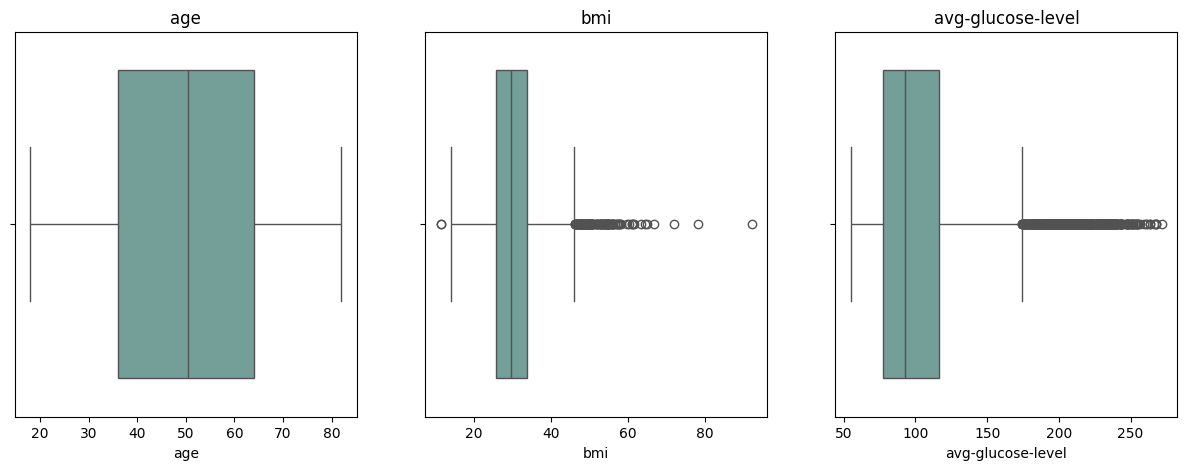

In [24]:
# Specify the numerical columns to plot
num_cols = ['age','bmi','avg-glucose-level']

# Create a figure with a specific size
plt.figure(figsize=(15, 5))
# Loop through the numerical columns and create a boxplot for each
for i in range(3) :
    plt.subplot(1,3,i+1)

    sns.boxplot(x=df[num_cols[i]],color='#6DA59D')
    plt.title(num_cols[i])

# display all the plots, allowing you to visually assess the distribution and
# potential outliers for each of the numerical features.
plt.show()

In the paper, the authors have removed the single lowest bmi value and we've replicated the same procedure in the other notebook. Here, instead, we are going to filter the outliers using the inter-quartile method.

In [25]:
# Loop through the specified columns to remove outliers
for col in ['bmi', 'avg-glucose-level']:
        # Calculate the first quartile (25th percentile)
        Q1 = df[col].quantile(0.25)
        # Calculate the third quartile (75th percentile)
        Q3 = df[col].quantile(0.75)
        # Calculate the interquartile range (IQR)
        IQR = Q3 - Q1
        # Calculate the lower bound for outliers
        lower_bound = Q1 - 1.5 * IQR
        # Calculate the upper bound for outliers
        upper_bound = Q3 + 1.5 * IQR
        # Filter the DataFrame to keep only rows where the column value is within the bounds
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3562 entries, 2 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             3562 non-null   object 
 1   age                3562 non-null   float64
 2   hypertension       3562 non-null   int64  
 3   heart-disease      3562 non-null   int64  
 4   ever-married       3562 non-null   object 
 5   work-type          3562 non-null   object 
 6   Residence-type     3562 non-null   object 
 7   avg-glucose-level  3562 non-null   float64
 8   bmi                3562 non-null   float64
 9   smoking-status     3562 non-null   object 
 10  stroke             3562 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 333.9+ KB


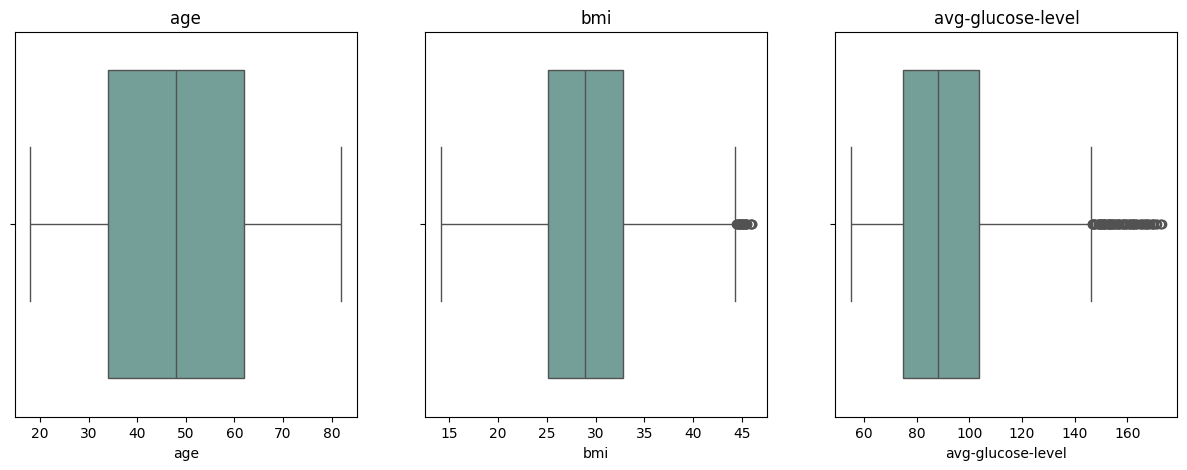

In [26]:
# Specify the numerical columns to plot
num_cols = ['age','bmi','avg-glucose-level']

# Create a figure with a specific size
plt.figure(figsize=(15, 5))
# Loop through the numerical columns and create a boxplot for each
for i in range(3) :
    plt.subplot(1,3,i+1)

    sns.boxplot(x=df[num_cols[i]],color='#6DA59D')
    plt.title(num_cols[i])
# Display all the plots
plt.show()

## Dataset Description

In [27]:
# Calculate the number of occurrences for each class in the 'stroke' column (0: no stroke, 1: stroke)
stroke_count =df['stroke'].value_counts()
# Calculate and print the percentage of stroke occurrences (where 'stroke' == 1)
print("Stroke percentage: {:.2f}%".format(100 * (stroke_count[1] / (stroke_count[0] + stroke_count[1]))))

Stroke percentage: 4.63%


In [28]:
# Calculate the number of occurrences for each gender in the 'gender' column
gender_count = df['gender'].value_counts()
# Print the number of males in the dataset
print('Number of males: ', gender_count['Male'])
# Print the number of females in the dataset
print('Number of females: ', gender_count['Female'])

Number of males:  1376
Number of females:  2186


In [29]:
# Calculate the number of occurrences for each value in the 'hypertension' column
hypertension_count =df['hypertension'].value_counts()
# Calculate and print the percentage of patients with hypertension
print("Hypertension percentage: {:.2f}%".format(100 *( hypertension_count[1]/(hypertension_count[0]+hypertension_count[1]))))

Hypertension percentage: 9.21%


In [30]:
# Calculate the number of occurrences for each value in the 'heart-disease' column
heart_disease_count =df['heart-disease'].value_counts()
# Calculate and print the percentage of patients with heart disease
print("Hearth disease percentage: {:.2f}%".format(100 * (heart_disease_count[1]/(heart_disease_count[0]+heart_disease_count[1]))))

Hearth disease percentage: 4.86%


In [31]:
# Count the occurrences of each value in the 'ever-married' column
ever_married_count =df['ever-married'].value_counts()
# Calculate the percentage of married individuals
print("Married percentage: {:.2f}%".format(100 * (ever_married_count[0]/(ever_married_count[0]+ever_married_count[1]))))

Married percentage: 76.92%


<ipython-input-31-e85b29941813>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Married percentage: {:.2f}%".format(100 * (ever_married_count[0]/(ever_married_count[0]+ever_married_count[1]))))


In [32]:
# Count the occurrences of each value in the 'work-type' column
work_type_count =df['work-type'].value_counts()
# Calculate and print the percentage of 'Private' work type
print("Private percentage: {:.2f}%".format(100 * (work_type_count[0]/(work_type_count[0]+work_type_count[1]+work_type_count[2]+work_type_count[3]))))
# Calculate and print the percentage of 'Self-employed' work type
print("Self-employed percentage: {:.2f}%".format(100 * (work_type_count[1]/(work_type_count[0]+work_type_count[1]+work_type_count[2]+work_type_count[3]))))
# Calculate and print the percentage of 'Gov' work type
print("Gov percentage: {:.2f}%".format(100 * (work_type_count[2]/(work_type_count[0]+work_type_count[1]+work_type_count[2]+work_type_count[3]))))
# Calculate and print the percentage of 'Never Worked' work type
print("Never Worked fraction: {:.1f}%".format(100 * (work_type_count[3]/(work_type_count[0]+work_type_count[1]+work_type_count[2]+work_type_count[3]))))

Private percentage: 66.25%
Self-employed percentage: 18.30%
Gov percentage: 15.30%
Never Worked fraction: 0.1%


<ipython-input-32-f98053db87e2>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Private percentage: {:.2f}%".format(100 * (work_type_count[0]/(work_type_count[0]+work_type_count[1]+work_type_count[2]+work_type_count[3]))))
<ipython-input-32-f98053db87e2>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Self-employed percentage: {:.2f}%".format(100 * (work_type_count[1]/(work_type_count[0]+work_type_count[1]+work_type_count[2]+work_type_count[3]))))
<ipython-input-32-f98053db87e2>:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always

In [33]:
# Count the occurrences of each value in the 'Residence-type' column
residence_type_count =df['Residence-type'].value_counts()
# Calculate and print the percentage of 'Urban' residence type
print("Urban percentage: {:.2f}%".format(100 * (residence_type_count[0]/(residence_type_count[0]+residence_type_count[1]))))
# Calculate and print the percentage of 'Rural' residence type
print("Rural pergentage: {:.2f}%".format(100 * (residence_type_count[1]/(residence_type_count[0]+residence_type_count[1]))))

Urban percentage: 50.93%
Rural pergentage: 49.07%


<ipython-input-33-979ba9ca3688>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Urban percentage: {:.2f}%".format(100 * (residence_type_count[0]/(residence_type_count[0]+residence_type_count[1]))))
<ipython-input-33-979ba9ca3688>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Rural pergentage: {:.2f}%".format(100 * (residence_type_count[1]/(residence_type_count[0]+residence_type_count[1]))))


In [34]:
# Count the occurrences of each value in the 'smoking-status' column
smoking_status_count =df['smoking-status'].value_counts()
# Calculate and print the percentage of 'Never Smoked'
print("Never Smoked fraction: {:.2f}%".format(100 * (smoking_status_count[0]/(smoking_status_count[0]+smoking_status_count[1]+smoking_status_count[2]))))
# Calculate and print the percentage of 'Formerly Smoked'
print("Formely Smoked fraction: {:.2f}%".format(100 * (smoking_status_count[1]/(smoking_status_count[0]+smoking_status_count[1]+smoking_status_count[2]))))
# Calculate and print the percentage of 'Smokes'
print("Smokes fraction: {:.2f}%".format(100 * (smoking_status_count[2]/(smoking_status_count[0]+smoking_status_count[1]+smoking_status_count[2]))))

Never Smoked fraction: 56.96%
Formely Smoked fraction: 22.07%
Smokes fraction: 20.97%


<ipython-input-34-c30bf61c2d2c>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Never Smoked fraction: {:.2f}%".format(100 * (smoking_status_count[0]/(smoking_status_count[0]+smoking_status_count[1]+smoking_status_count[2]))))
<ipython-input-34-c30bf61c2d2c>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Formely Smoked fraction: {:.2f}%".format(100 * (smoking_status_count[1]/(smoking_status_count[0]+smoking_status_count[1]+smoking_status_count[2]))))
<ipython-input-34-c30bf61c2d2c>:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will al

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3562 entries, 2 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             3562 non-null   object 
 1   age                3562 non-null   float64
 2   hypertension       3562 non-null   int64  
 3   heart-disease      3562 non-null   int64  
 4   ever-married       3562 non-null   object 
 5   work-type          3562 non-null   object 
 6   Residence-type     3562 non-null   object 
 7   avg-glucose-level  3562 non-null   float64
 8   bmi                3562 non-null   float64
 9   smoking-status     3562 non-null   object 
 10  stroke             3562 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 333.9+ KB


In [36]:
df.head()

,gender,age,hypertension,heart-disease,ever-married,work-type,Residence-type,avg-glucose-level,bmi,smoking-status,stroke
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
6,Male,74.0,1,1,Yes,Private,Rural,70.09,27.400000,never smoked,1
7,Female,69.0,0,0,No,Private,Urban,94.39,22.800000,never smoked,1
8,Female,59.0,0,0,Yes,Private,Rural,76.15,30.432752,formerly smoked,1


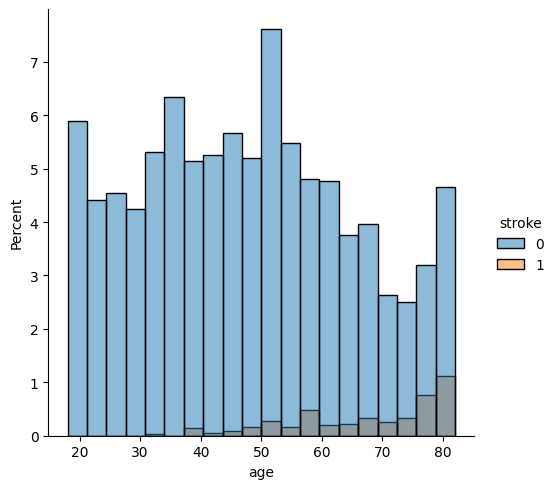

In [37]:
# Creating an histogram to visualize the distribution of the 'age' feature in the DataFrame.
# The histogram is segmented by the stroke variable, which means it shows separate distributions
# for individuals who have had a stroke (stroke=1) and those who have not (stroke=0).
sns.displot(data = df, x='age', hue='stroke',  bins=20, kde=False, color='blue', stat='percent')

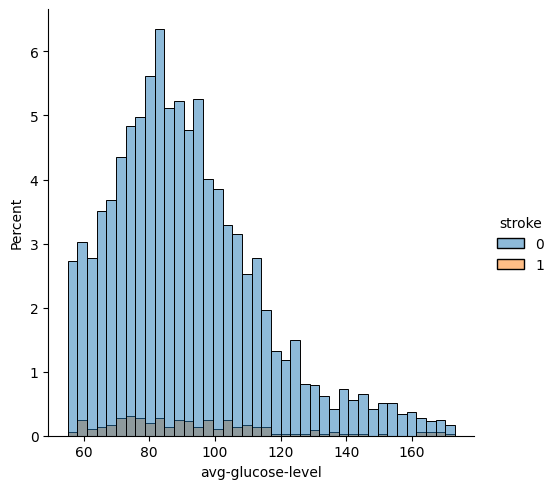

In [38]:
# This code generates an histogram plot to visualize the relationship
# between the average glucose level and the occurrence of stroke.
# The plot helps to visualize how the distribution of avg-glucose-level
# differs between individuals with and without a stroke.
sns.displot(data = df, x='avg-glucose-level', hue='stroke', bins=40, kde=False, color='blue', stat='percent')

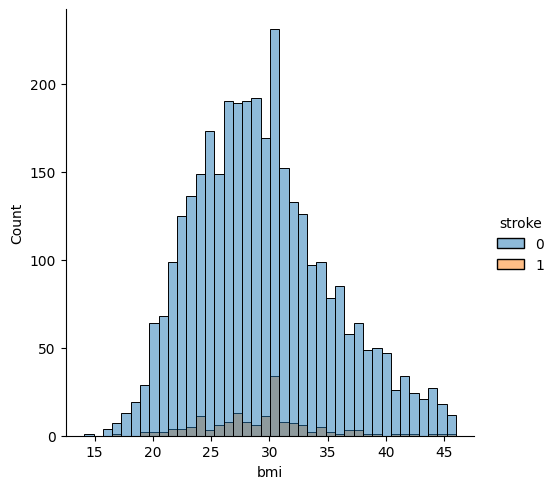

In [39]:
# This code generates an histogram to visualize the relationship
# between bmi and the occurrence of stroke.
# This plot helps to visualize the distribution of BMI values across
# individuals with and without a stroke, allowing for comparison of BMI patterns
# between the two groups.
sns.displot(data=df, x='bmi', hue='stroke', bins=40, kde=False, color='blue')

## Oversampling

In [40]:
# Create a numpy array of feature names by excluding the last column (the target variable 'stroke')
features = np.array(df.columns[:-1])
print(features)

# Drop the 'stroke' column from the DataFrame df to create the feature matrix X
X = df.drop(['stroke'], axis = 1) # Data
# Extract the 'stroke' column from the DataFrame df as the target variable y
y = df['stroke'] # Target

['gender' 'age' 'hypertension' 'heart-disease' 'ever-married' 'work-type'
 'Residence-type' 'avg-glucose-level' 'bmi' 'smoking-status']


In [41]:
# Calculating and displaying the count of each category in the target
# variable 'stroke' allowing us to understand the distribution of the classes in the dataset.
y.value_counts()

,count
stroke,
0,3397
1,165


Now, we're going to generate a pie chart to visualize the proportions of the target variable in the dataset.
A pie chart can provide initial insights into the target variable's distribution, for example, if the chart shows that 'stroke' cases are much smaller in proportion compared to 'no stroke' cases, it highlights the need for techniques to handle class imbalance in modeling.

<Axes: ylabel='count'>

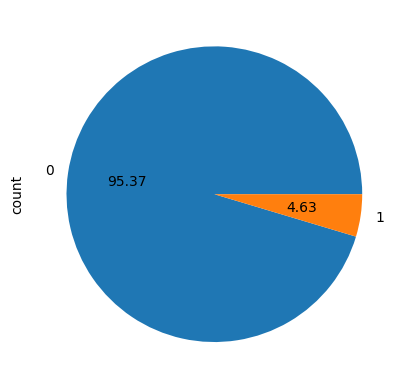

In [42]:
# Creating a pie chart to visualize the distribution of the target variable 'stroke'.
y.value_counts().plot.pie(autopct = "%.2f")

We can observe a significant imbalance between the number of stroke and non-stroke samples in the dataset. This imbalance poses a challenge, as the model might become biased towards predicting the majority class (non-stroke) more frequently. To address this issue, we will apply oversampling techniques to increase the number of stroke samples, which represent the minority class, in order to balance the dataset and improve the model's performance.

In [43]:
X.head()

,gender,age,hypertension,heart-disease,ever-married,work-type,Residence-type,avg-glucose-level,bmi,smoking-status
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes
6,Male,74.0,1,1,Yes,Private,Rural,70.09,27.400000,never smoked
7,Female,69.0,0,0,No,Private,Urban,94.39,22.800000,never smoked
8,Female,59.0,0,0,Yes,Private,Rural,76.15,30.432752,formerly smoked


### Splitting the Dataset

It is generally recommended to perform oversampling only on the training dataset, rather than on the entire dataset. This ensures that the test dataset remains a representative sample of the original data distribution and is not influenced by the oversampling process.
To adhere to this best practice, we should first split the dataset into training and testing subsets. After the split, we can apply oversampling techniques to the training dataset only. This approach contrasts with what was done in the other notebook, where oversampling was applied to the entire original dataset before splitting it into training and testing subsets.
By oversampling only the training set, we avoid introducing bias into the test set and ensure a more accurate evaluation of the model’s performance on unseen data.

In [44]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2) # 20% of the data will be used for testing, and 80% for training

In [45]:
X_train.head()

,gender,age,hypertension,heart-disease,ever-married,work-type,Residence-type,avg-glucose-level,bmi,smoking-status
3202,Female,74.0,0,0,No,Self-employed,Urban,89.52,39.200000,never smoked
4985,Female,39.0,0,0,Yes,Govt_job,Urban,109.03,24.900000,smokes
1539,Male,30.0,0,0,Yes,Private,Urban,91.23,30.432752,smokes
84,Male,58.0,0,0,Yes,Private,Urban,71.20,30.432752,smokes
1593,Male,31.0,0,0,Yes,Private,Urban,71.31,25.800000,never smoked


To address the class imbalance in our dataset, we will apply the SMOTE (Synthetic Minority Over-sampling Technique) method.
In the paper the authors have oversampled the whole dataset, we will oversample only the train dataset.
Moreover, we will use a different version of SMOTE, the SMOTENC, which is more suitable for datasets with categorical features.

In [46]:
from imblearn.over_sampling import SMOTE, SMOTENC
from sklearn.preprocessing import OrdinalEncoder, RobustScaler

# Create copies of the training feature matrix and target variable to avoid altering the original data
X_tmp = X_train.copy()
y_tmp = y_train.copy()

# Apply SMOTENC to oversample the minority class in the categorical features
# SMOTENC is used when there are categorical features in the dataset
smote = SMOTENC(sampling_strategy='minority', categorical_features=['work-type', 'smoking-status', 'gender', 'ever-married', 'Residence-type', 'hypertension', 'heart-disease'])
X_smote, y_smote = smote.fit_resample(X_tmp, y_tmp)

X_smote.describe()

,age,hypertension,heart-disease,avg-glucose-level,bmi
count,5422.000000,5422.000000,5422.000000,5422.000000,5422.000000
mean,57.256037,0.095721,0.034120,91.951833,29.156317
std,17.812033,0.294236,0.181555,23.453966,5.041566
min,18.000000,0.000000,0.000000,55.120000,14.100000
25%,45.000000,0.000000,0.000000,74.620563,25.800000
50%,59.000000,0.000000,0.000000,87.922005,29.000000
75%,74.357600,0.000000,0.000000,104.903017,31.654743
max,82.000000,1.000000,1.000000,173.140000,46.000000


In [47]:
X_smote['work-type'].value_counts()

,count
work-type,
Private,3894
Self-employed,1056
Govt_job,467
Never_worked,5


In [48]:
X_smote.head()

,gender,age,hypertension,heart-disease,ever-married,work-type,Residence-type,avg-glucose-level,bmi,smoking-status
0,Female,74.0,0,0,No,Self-employed,Urban,89.52,39.200000,never smoked
1,Female,39.0,0,0,Yes,Govt_job,Urban,109.03,24.900000,smokes
2,Male,30.0,0,0,Yes,Private,Urban,91.23,30.432752,smokes
3,Male,58.0,0,0,Yes,Private,Urban,71.20,30.432752,smokes
4,Male,31.0,0,0,Yes,Private,Urban,71.31,25.800000,never smoked


In [49]:
# Create copies of the oversampled feature matrix and target variable for balanced data
X_balanced = X_smote.copy()
y_balanced = y_smote.copy()

# Update the training feature matrix and target variable with the oversampled data
X_train = X_smote.copy()
y_train = y_smote.copy()

# Convert 'hypertension' and 'heart-disease' columns to integer type
# This step is necessary because after oversampling, these columns might have become of type 'object' (string)
# Converting them to integers ensures that they are in the correct format for subsequent processing
X_train['hypertension'] = X_train['hypertension'].astype(int)
X_train['heart-disease'] = X_train['heart-disease'].astype(int)

In [50]:
# Create a new DataFrame df_balanced by combining the balanced feature matrix and target variable
# Assign the feature matrix X_balanced to df_balanced
df_balanced = X_balanced
# Add the target variable y_balanced to df_balanced as a new column 'stroke'
# This combines the features and target into a single DataFrame for easier inspection or further processing
df_balanced['stroke'] = y_balanced
df_balanced.head()

,gender,age,hypertension,heart-disease,ever-married,work-type,Residence-type,avg-glucose-level,bmi,smoking-status,stroke
0,Female,74.0,0,0,No,Self-employed,Urban,89.52,39.200000,never smoked,0
1,Female,39.0,0,0,Yes,Govt_job,Urban,109.03,24.900000,smokes,0
2,Male,30.0,0,0,Yes,Private,Urban,91.23,30.432752,smokes,0
3,Male,58.0,0,0,Yes,Private,Urban,71.20,30.432752,smokes,1
4,Male,31.0,0,0,Yes,Private,Urban,71.31,25.800000,never smoked,0


In [51]:
df_balanced.describe()

,age,hypertension,heart-disease,avg-glucose-level,bmi,stroke
count,5422.000000,5422.000000,5422.000000,5422.000000,5422.000000,5422.000000
mean,57.256037,0.095721,0.034120,91.951833,29.156317,0.500000
std,17.812033,0.294236,0.181555,23.453966,5.041566,0.500046
min,18.000000,0.000000,0.000000,55.120000,14.100000,0.000000
25%,45.000000,0.000000,0.000000,74.620563,25.800000,0.000000
50%,59.000000,0.000000,0.000000,87.922005,29.000000,0.500000
75%,74.357600,0.000000,0.000000,104.903017,31.654743,1.000000
max,82.000000,1.000000,1.000000,173.140000,46.000000,1.000000


## Graphs

Now, we'll compare the distribution of the 'stroke' class between the original imbalanced dataset and the balanced dataset. A histogram will provide a clear visualization of these distributions, highlighting the effect of the balancing process.

<Axes: xlabel='stroke', ylabel='count'>

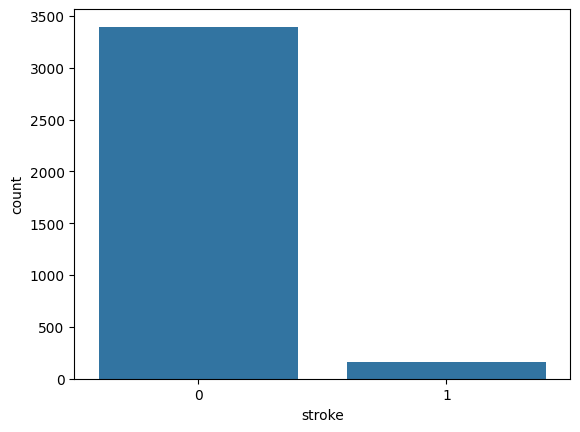

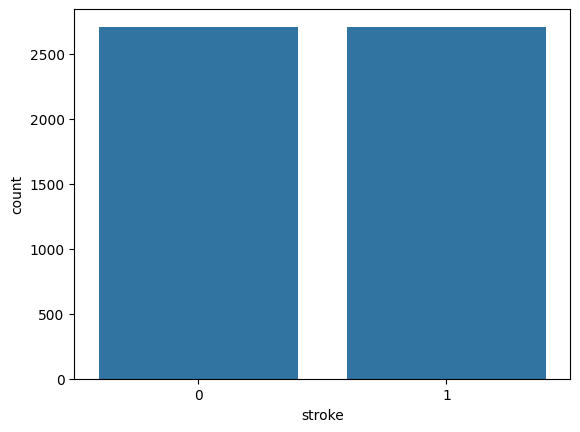

In [52]:
# Plot the distribution of 'stroke' in the original dataset
sns.countplot(x='stroke', data=df)
plt.figure()
# Plot the distribution of 'stroke' in the balanced dataset
sns.countplot(x='stroke', data=df_balanced)

We can clearly see that the dataset is now balanced. The stroke and non-stroke patients are now equally represented in the train dataset.

### Feature Distribution Histograms in the Balanced Training Set.

<Axes: xlabel='age_bucket', ylabel='percent'>

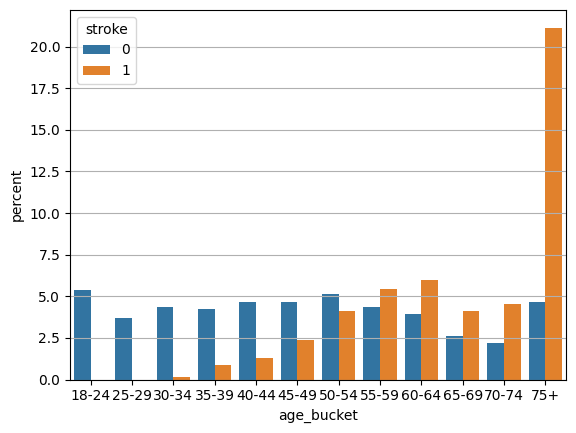

In [53]:
plt.grid()
# Define age buckets as labels for age ranges
age_labels = ['18-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75+']
# Create a copy of the balanced dataset to avoid modifying the original
dataset_bal_copy = df_balanced.copy()
# Bin the 'age' column into categories defined by age_labels
dataset_bal_copy['age_bucket'] = pd.cut(dataset_bal_copy['age'], bins=[17, 24, 29, 34, 39, 44, 49, 54, 59, 64, 69, 74, 100], labels=age_labels)
# Plot the distribution of 'age_bucket' with 'stroke' categories, showing percentages
sns.countplot(x='age_bucket', hue='stroke', order=age_labels, data=dataset_bal_copy, stat='percent')

As also observed in the paper, the number of elderly patients who had a stroke is higher than the number of young patients who had a stroke. This is a common observation in the medical field.

<Axes: xlabel='hypertension', ylabel='percent'>

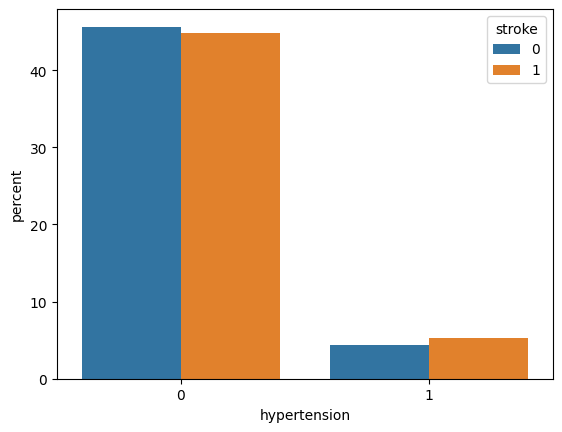

In [54]:
# Plot the distribution of 'hypertension' with 'stroke' categories, showing percentages
sns.countplot(x='hypertension', hue='stroke', data=df_balanced, stat='percent')

This plot illustrates the percentage distribution of stroke occurrences in relation to hypertension status. It shows how the prevalence of stroke varies between individuals with and without hypertension. As in the original paper, we observe that an essential ratio of participants who had a stroke has not been diagnosed with hypertension.

<Axes: xlabel='heart-disease', ylabel='percent'>

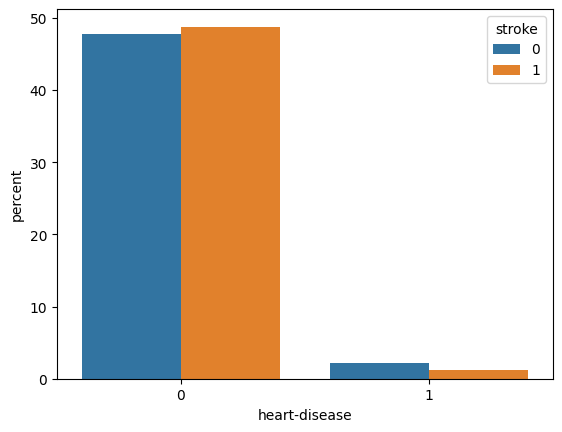

In [55]:
# Plot the distribution of 'heart-disease' with 'stroke' categories, showing percentages
sns.countplot(x='heart-disease', hue='stroke', data=df_balanced, stat='percent')

This plot illustrates the percentage distribution of stroke occurrences in relation to heart disease. It shows how the prevalence of stroke varies between individuals with and without a heart disease. As in the original paper, we observe that an essential ratio of participants who had a stroke has not been diagnosed with an heart disease.

The fact that both the heart disease class and the hypertension seem not to contribute significantly to the model is also observed in the paper. The authors explain it as a possible consequence of the lack of screening. When these simptoms are not found, they can not be acted on.

<Axes: xlabel='smoking-status', ylabel='percent'>

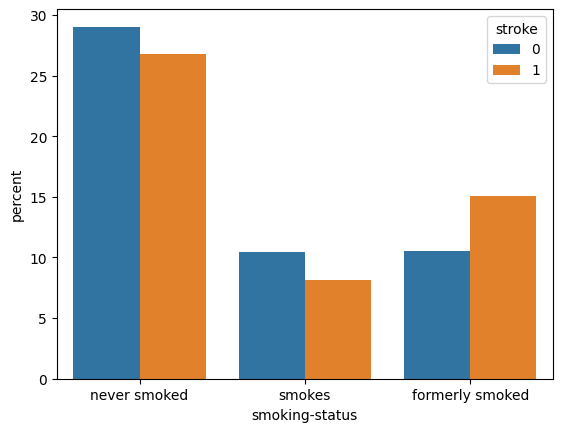

In [56]:
# Plot the distribution of 'smoking-status' with 'stroke' categories, showing percentages
sns.countplot(x='smoking-status', hue='stroke', data=df_balanced, stat='percent')

The plot above depicts the participants' distribution among the three categories of smoking habits.

<Axes: xlabel='bmi_bucket', ylabel='percent'>

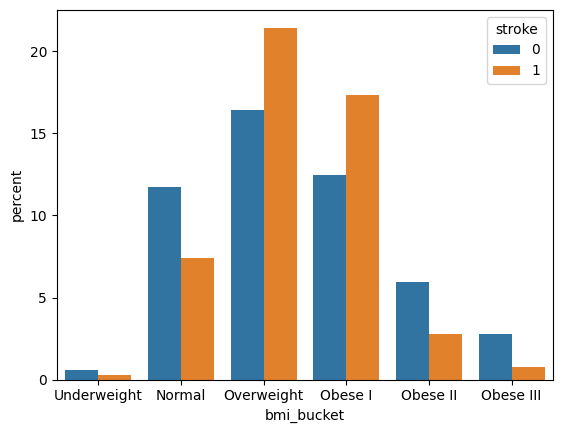

In [57]:
# Define BMI categories as labels for different BMI ranges
bmi_labels = ['Underweight', 'Normal', 'Overweight', 'Obese I', 'Obese II', 'Obese III']
# Bin the 'bmi' column into categories defined by bmi_labels
dataset_bal_copy['bmi_bucket'] = pd.cut(dataset_bal_copy['bmi'], bins=[0, 18.5, 24.9, 29.9, 34.9, 39.9, 100], labels=bmi_labels)
# Plot the distribution of 'bmi_bucket' with 'stroke' categories, showing percentages
sns.countplot(x='bmi_bucket', hue='stroke',order=bmi_labels,  data=dataset_bal_copy, stat='percent')

The BMI plot suggests that most of the patients that had suffered from a stroke are either overweight or obese.
The importance of BMI is also captured by the ranking score assigned by the selected feature importance method in the balanced data.

<Axes: xlabel='Residence-type', ylabel='percent'>

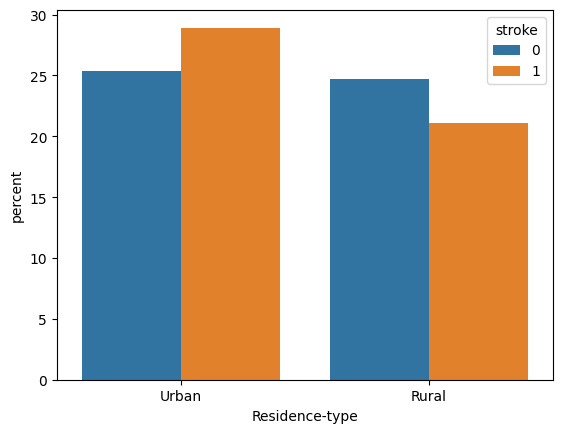

In [58]:
# Plot the distribution of 'Residence-type' with 'stroke' categories, showing percentages
sns.countplot(x='Residence-type', hue='stroke', data=df_balanced, stat='percent')

The urban residence seems to be more common among the patients that had a stroke.

<Axes: xlabel='work-type', ylabel='percent'>

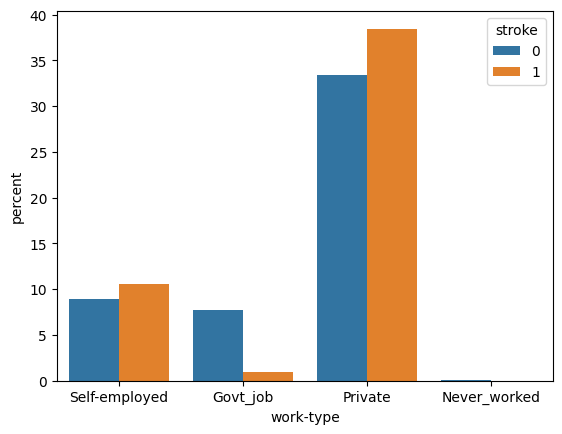

In [59]:
# Plot the distribution of 'work-type' with 'stroke' categories, showing percentages
sns.countplot(x='work-type', hue='stroke', data=df_balanced, stat='percent')

As observed in the paper, the private sector seems to have a higher percentage of stroke patients. However, we should also point out that the private sector also has a higher representation in the dataset.

<Axes: xlabel='gender', ylabel='percent'>

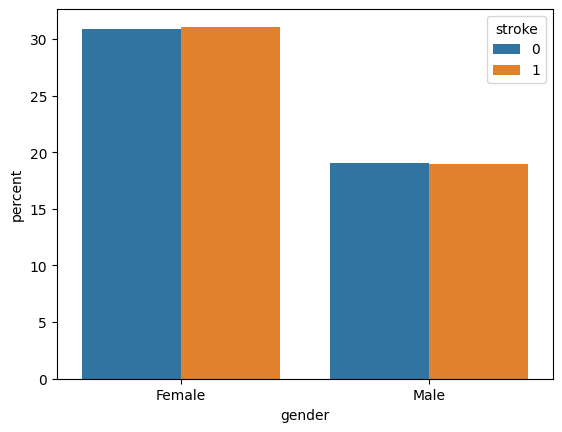

In [60]:
# Plot the distribution of 'gender' with 'stroke' categories, showing percentages
sns.countplot(x='gender', hue='stroke', data=df_balanced, stat='percent')

In [61]:
df_balanced.head()

,gender,age,hypertension,heart-disease,ever-married,work-type,Residence-type,avg-glucose-level,bmi,smoking-status,stroke
0,Female,74.0,0,0,No,Self-employed,Urban,89.52,39.200000,never smoked,0
1,Female,39.0,0,0,Yes,Govt_job,Urban,109.03,24.900000,smokes,0
2,Male,30.0,0,0,Yes,Private,Urban,91.23,30.432752,smokes,0
3,Male,58.0,0,0,Yes,Private,Urban,71.20,30.432752,smokes,1
4,Male,31.0,0,0,Yes,Private,Urban,71.31,25.800000,never smoked,0


## Feature Ranking

In classification analysis, feature importance constitutes a core component that facilitates the development of accurate and high-fidelity ML models. The accuracy of the classifiers improves until an optimal number of features is considered. The performance of ML models may deteriorate if irrelevant features are assumed for the models' training. Feature ranking is defined as the process of assigning a score to each feature in a dataset. In this way, the most significant or relevant ones are considered, namely, those ones that may contribute greatly to the target variable to enhance the model accuracy.

In [62]:
X_train.head()

,gender,age,hypertension,heart-disease,ever-married,work-type,Residence-type,avg-glucose-level,bmi,smoking-status
0,Female,74.0,0,0,No,Self-employed,Urban,89.52,39.200000,never smoked
1,Female,39.0,0,0,Yes,Govt_job,Urban,109.03,24.900000,smokes
2,Male,30.0,0,0,Yes,Private,Urban,91.23,30.432752,smokes
3,Male,58.0,0,0,Yes,Private,Urban,71.20,30.432752,smokes
4,Male,31.0,0,0,Yes,Private,Urban,71.31,25.800000,never smoked


<Axes: xlabel='stroke', ylabel='count'>

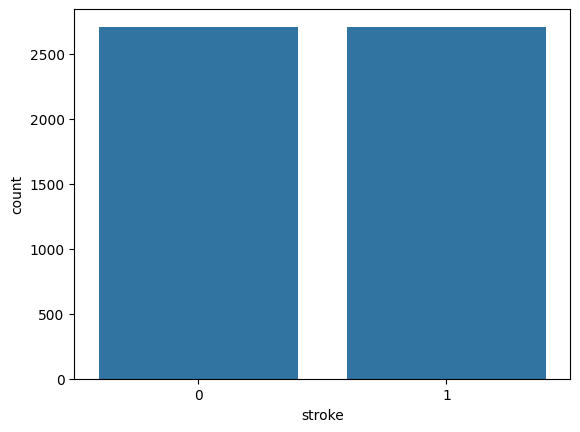

In [63]:
# Create a copy of the training features dataset
df_train = X_train.copy()
# Add the target variable 'stroke' to the training features dataset
df_train['stroke'] = y_train

# Plot the distribution of 'stroke' in the training dataset
sns.countplot(x='stroke', data=df_train)

### Random forest classifier to select the most important features

We start with the pre-processing part, in which we one-hot encode the categorical features and scale the numerical ones.

In [64]:
# Create copies of the training features and target variables
X_tmp = X_train.copy()
y_tmp = y_train.copy()

# Apply one-hot encoding to categorical features
dummies = pd.get_dummies(X_tmp[cathegorical_features])  # Create one-hot encoded columns for categorical features
X_tmp = X_tmp.drop(cathegorical_features, axis=1)       # Drop the original categorical features
X_tmp = pd.concat([X_tmp, dummies], axis=1)             # Concatenate the one-hot encoded columns with the remaining dataset

# Store the names of all features after encoding
tmp_features = X_tmp.columns

# Apply ordinal encoding to binary features
oe = OrdinalEncoder()
X_tmp[binary_features] = oe.fit_transform(X_tmp[binary_features])

# Normalize the data using RobustScaler
scaler = RobustScaler()
X_tmp = scaler.fit_transform(X_tmp)

We will now proceed with training the Random Forest classifier, a powerful ensemble learning method that combines multiple decision trees to improve prediction accuracy and control overfitting. By aggregating the predictions of these trees, the Random Forest model provides a robust and reliable estimate of feature importance, helping us to better understand the key factors influencing our target variable.

{'heart-disease': 0.014719396541870943, 'hypertension': 0.019332357783695193, 'Residence-type': 0.03007624704248576, 'gender': 0.03188017663385872, 'ever-married': 0.043278397348579044, 'smoking-status': 0.04708259988993676, 'work-type': 0.06963643625899932, 'bmi': 0.16014504194101348, 'avg-glucose-level': 0.2057031455871755, 'age': 0.3781462009723853}


<BarContainer object of 10 artists>

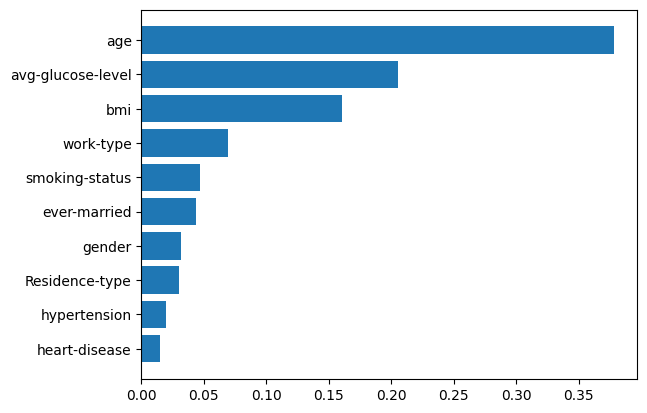

In [65]:
from sklearn.ensemble import RandomForestClassifier

# Get the names of the dataset features (excluding the target variable)
dataset_features = df.columns[:-1]

# Initialize the RandomForestClassifier with a fixed random state for reproducibility
rf_classifier = RandomForestClassifier(random_state=42)

# Initialize a dictionary to hold feature importances
importances = dict()
for f in dataset_features:
    importances[f] = 0

# Fit the RandomForestClassifier to the training data
rf_classifier.fit(X_tmp, y_train)

# Get the importance scores of each feature and zip them with their respective feature names
feature_importance = list(zip(tmp_features, rf_classifier.feature_importances_))

# This loop iterates through each feature in the original dataset and adds up the importance scores
# for that feature across all one-hot encoded columns that correspond to it.
for f in dataset_features:
    for f2, imp in feature_importance:
        if f in f2:
            importances[f] += imp

# Sort the features by their importances in ascending order
importances = dict(sorted(importances.items(), key=lambda item: item[1]))
print(importances)
# Plot the feature importances as a horizontal bar chart
plt.barh([k for k, _ in importances.items()],[v for _, v in importances.items()])

We also compute feature ranking using a Mutual Information classifier, which evaluates the statistical dependency between each feature and the target variable. This method quantifies how much information each feature contributes to predicting the target, providing insight into the relevance and importance of each feature in the model. By assessing these dependencies, we can identify which features have the strongest association with the target variable, guiding feature selection and improving model performance.

{'gender': 0.0, 'hypertension': 0.0022265339974454346, 'heart-disease': 0.002298674590124561, 'smoking-status': 0.0041014985131389015, 'Residence-type': 0.015972460033796487, 'avg-glucose-level': 0.022742188213728864, 'work-type': 0.042772020801601585, 'ever-married': 0.044736727536612175, 'bmi': 0.41878248432401355, 'age': 0.5244980957213754}


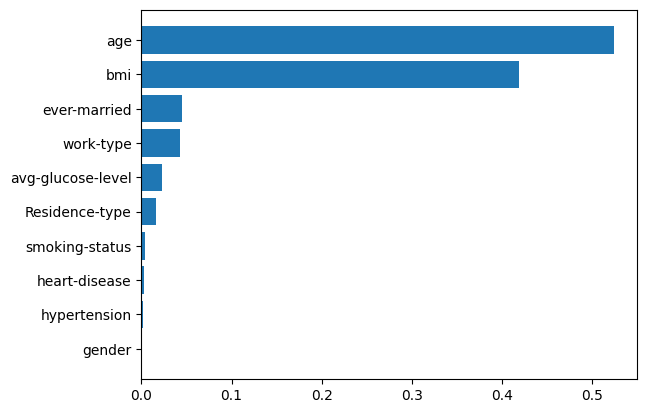

In [66]:
from sklearn.feature_selection import mutual_info_classif

# Compute the mutual information between each feature and the target variable.
# Mutual information measures the dependency between the feature and the target.
mi = mutual_info_classif(X_tmp, y_tmp, random_state=42)

# Combine the feature names with their corresponding mutual information scores.
feature_importance = list(zip(tmp_features, mi))

# Initialize a dictionary to store the cumulative importance for each original feature.
importances = dict()
for f in dataset_features:
    importances[f] = 0

# This loop iterates through each feature in the original dataset and adds up the mutual information scores
# for that feature across all one-hot encoded columns that correspond to it.
for f in dataset_features:
    for f2, imp in feature_importance:
        if f in f2:
            importances[f] += imp

# Sort the feature importance dictionary by the importance values in ascending order.
importances = dict(sorted(importances.items(), key=lambda item: item[1]))
# Create a horizontal bar plot to visualize the importance of each feature.
plt.barh([k for k, _ in importances.items()],[v for _, v in importances.items()])
print(importances)

Now, we will train a Decision Tree Classifier to implement the information gain method, which is used to evaluate and rank the importance of features in predicting the target variable. By examining the reduction in entropy (or uncertainty) at each split, the model identifies which features contribute most to accurate classification, allowing us to understand the relative significance of each feature in the dataset.

{'ever-married': 0.014013752675366867, 'heart-disease': 0.019315543718763463, 'hypertension': 0.024578907516884383, 'Residence-type': 0.0252596825371996, 'gender': 0.033396459192267226, 'smoking-status': 0.04170330257846996, 'work-type': 0.05487727231406642, 'bmi': 0.1453671945899835, 'avg-glucose-level': 0.20962718851832213, 'age': 0.4318606963586763}


<BarContainer object of 10 artists>

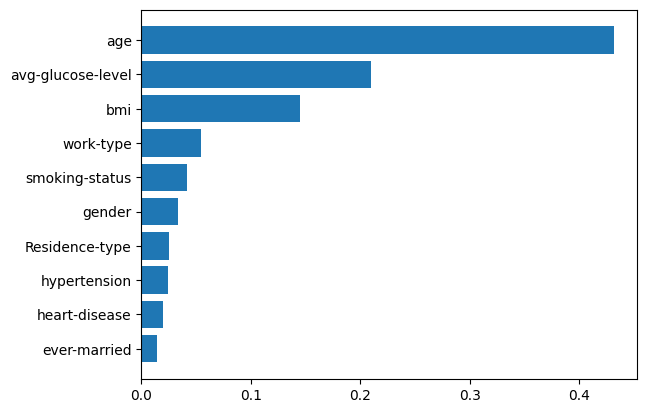

In [67]:
from sklearn.tree import DecisionTreeClassifier

# Initialize the Decision Tree classifier with 'entropy' as the criterion for measuring the quality of a split.
dt_classifier = DecisionTreeClassifier(criterion='entropy')

# Create a dictionary to store the cumulative feature importance for each feature in the dataset.
importances = dict()
for f in dataset_features:
    importances[f] = 0

# Fit the Decision Tree classifier on the training data.
dt_classifier.fit(X_tmp, y_tmp)

# Extract the feature importance scores from the trained Decision Tree model,
# and zip them with their corresponding feature names.
feature_importance = list(zip(tmp_features, dt_classifier.feature_importances_))

# This loop iterates through each feature in the original dataset and adds up the importance scores
# for that feature across all one-hot encoded columns that correspond to it.
for f in dataset_features:
    for f2, imp in feature_importance:
        if f in f2:
            importances[f] += imp

# Sort the feature importance dictionary by the importance values in ascending order.
importances = dict(sorted(importances.items(), key=lambda item: item[1]))
print(importances)
# Create a horizontal bar plot to visualize the importance of each feature.
plt.barh([k for k, _ in importances.items()],[v for _, v in importances.items()])

Both the Random Forest and the Information Gain method  show that age is the the most influent and relevant risk factor for the occurrence of stroke. Both feature ranking algorithms seem to agree on the importance of BMI.
Also hypertension is among the least important features in both models. This is consistent with the paper.
Moreover, all scores are positive, which means that the features may enhance the models' performance.

# Model training



In this section, we will train the models used in the classification framework for predicting stroke occurrence, as outlined in the referenced paper. We will then compute key evaluation metrics, including Precision, Recall, F-Measure, AUC, and Accuracy, which are widely recognized in the relevant literature for assessing model performance.

In [68]:
# Initialize a dictionary to store confusion matrices for each model.
confusion_matrices = dict()

# Initialize a dictionary to store the mean cross-validation scores for each model.
cross_val_scores_mean = dict()

# Initialize a dictionary to store the accuracy scores for each model.
accuracy = dict()

# Initialize a dictionary to store the precision scores for each model.
precision = dict()

# Initialize a dictionary to store the recall scores for each model.
recall = dict()

# Initialize a dictionary to store the F1 scores (F-measure) for each model.
F_metric = dict()

# Initialize a dictionary to store the AUC (Area Under the Curve) scores for each model.
auc_score = dict()

In [69]:
print(X_train.shape)
X_train.head()

(5422, 10)


,gender,age,hypertension,heart-disease,ever-married,work-type,Residence-type,avg-glucose-level,bmi,smoking-status
0,Female,74.0,0,0,No,Self-employed,Urban,89.52,39.200000,never smoked
1,Female,39.0,0,0,Yes,Govt_job,Urban,109.03,24.900000,smokes
2,Male,30.0,0,0,Yes,Private,Urban,91.23,30.432752,smokes
3,Male,58.0,0,0,Yes,Private,Urban,71.20,30.432752,smokes
4,Male,31.0,0,0,Yes,Private,Urban,71.31,25.800000,never smoked


In [70]:
print(X_test.shape)
X_test.head()

(713, 10)


,gender,age,hypertension,heart-disease,ever-married,work-type,Residence-type,avg-glucose-level,bmi,smoking-status
2040,Female,57.0,0,0,Yes,Private,Urban,95.40,19.5,never smoked
1945,Male,33.0,0,0,Yes,Private,Urban,98.74,44.4,never smoked
981,Female,46.0,0,0,Yes,Private,Rural,109.22,20.1,never smoked
3873,Male,23.0,0,0,No,Private,Urban,82.53,20.7,smokes
3544,Male,41.0,0,0,Yes,Private,Rural,108.71,24.0,never smoked


To optimize the performance of our models, we will employ the GridSearchCV method for hyperparameter tuning. This approach allows us to systematically search through a predefined range of hyperparameters, identifying the combination that yields the best model performance. By fine-tuning these hyperparameters, we can enhance the predictive accuracy and robustness of each model.

Once the optimal hyperparameters are identified, we will re-train the models using these best settings. Additionally, we will implement ensemble learning techniques, specifically stacking and voting, to further improve our predictive capabilities by combining the strengths of multiple models. This comprehensive approach ensures that we achieve the highest possible performance in predicting stroke occurrences.

In [71]:
from sklearn.model_selection import GridSearchCV, GroupShuffleSplit
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from sklearn.metrics import make_scorer

# Set up a ColumnTransformer to handle different types of data: numerical, binary, and categorical features
processor = ColumnTransformer(
    transformers=[
        # Pass through numerical features unchanged
        ('num', 'passthrough', numerical_features),
        # One-hot encode binary features
        ('bool', OneHotEncoder(categories=[[0, 1], [0, 1], ['Male', 'Female'], ['Yes', 'No'], ['Urban', 'Rural']]), binary_features),
        # One-hot encode categorical features
        ('cat', OneHotEncoder(categories=[['Private', 'Self-employed', 'Govt_job', 'Never_worked'], ['smokes', 'never smoked', 'formerly smoked']]), cathegorical_features)])

# Apply StandardScaler to specific numerical features
scaler = ColumnTransformer(
    transformers=[
        ('num_scale', StandardScaler(), [1, 7, 8])
    ],  # Scale columns 1, 7, and 8
    remainder='passthrough')  # Leave the rest of the columns unchanged

# Define models and their hyperparameter grids for GridSearchCV
grid_models = [
               ('Naive Bayes', GaussianNB(),[{'var_smoothing': [1e-08, 1e-07, 1e-06]}]),
               ('Logistic Regression', LogisticRegression(),[{'C':[0.25,0.5,0.75,1],'random_state':[0], 'solver': ['newton-cg', 'lbfgs', 'liblinear'], 'max_iter':[1000]}]),
               ('SGD', SGDClassifier(), [{'loss': ['hinge', 'log_loss', 'modified_huber'],'penalty': ['l2', 'l1', 'elasticnet'],'alpha': [0.0001, 0.001, 0.01, 0.1]}]),
               ('KNN', KNeighborsClassifier(),[{'n_neighbors':[3,5,7,8,10], 'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski'], 'weights': ['uniform', 'distance']}]),
               ('Decision Tree', DecisionTreeClassifier(),[{'criterion':['gini','entropy'],'random_state':[0]}]),
               ('Random Forest', RandomForestClassifier(),[{'n_estimators':[100,150,200],'criterion':['gini','entropy'],'random_state':[0]}]),
               ('MLP', MLPClassifier(),[{'hidden_layer_sizes':[(10,),(20,), (25,)],'max_iter':[500],'learning_rate':['constant'], 'learning_rate_init':[0.003, 0.03, 0.3], 'momentum':[0.02,0.2], 'activation': ['relu', 'tanh']}])
               ]

# Define scoring metrics for model evaluation
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, zero_division=0),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score)
}

# Initialize an empty dictionary to store models with their best hyperparameters
models = dict()

# Loop through each model, perform GridSearchCV, and evaluate it
for k, m, param_grid in grid_models:
    # Initialize GridSearchCV with the model, its hyperparameters, and scoring metrics
    grid = GridSearchCV(estimator=m, param_grid = param_grid, scoring = scoring, cv = 10, refit='roc_auc') # f1 score is used as scoring metric, because it is the harmonic mean of precision and recall

    # Create a pipeline to preprocess data, scale it, and then fit the model
    pipeline = Pipeline([
        ('processor', processor), # Apply the preprocessing defined earlier
        ('scaler', scaler),       # Scale the data
        ('model', grid)           # Fit the model using GridSearchCV
    ])
    # Fit the pipeline on the training data
    pipeline.fit(X_train, y_train)
    # Make predictions on the test data
    y_pred = pipeline.predict(X_test)

    # Retrieve cross-validation results
    results = grid.cv_results_
    # Get the best score from cross-validation
    best_accuracy = grid.best_score_
    # Get the best hyperparameters
    best_param = grid.best_params_

    # Loop through each scoring metric and print the best score
    for scorer in scoring:
        best_index = results['rank_test_' + scorer].argmin()  # Find the index of the best score
        print(f"Best {scorer} score - cross validated: {results['mean_test_' + scorer][best_index]:.2f} (std: {results['std_test_' + scorer][best_index]:.2f})")

    # Store the best cross-validation score for the model
    cross_val_scores_mean[k] = best_accuracy

    # Calculate and store evaluation metrics for the model on the test set
    confusion_matrices[k] = confusion_matrix(y_test, y_pred)
    accuracy[k] = accuracy_score(y_test, y_pred)
    precision[k] = precision_score(y_test, y_pred)
    recall[k] = recall_score(y_test, y_pred)
    F_metric[k] = f1_score(y_test, y_pred)
    auc_score[k] = roc_auc_score(y_test, y_pred)

    # Save the model with the best hyperparameters
    models[k] = pipeline

    # Print the best hyperparameters and evaluation metrics
    print('Best Parameters : ',best_param)
    print('')

    print("10-fold cross validation score: ", cross_val_scores_mean[k])
    print("Accuracy: ", accuracy[k])
    print("Precision: ", precision[k])
    print("Recall: ", recall[k])
    print("F1 score: ", F_metric[k])
    print("AUC: ", auc_score[k])
    print('')
    print(classification_report(y_test, y_pred))
    print('----------------')
    print('')

Best accuracy score - cross validated: 0.68 (std: 0.03)
Best precision score - cross validated: 0.62 (std: 0.02)
Best recall score - cross validated: 0.90 (std: 0.04)
Best f1 score - cross validated: 0.74 (std: 0.03)
Best roc_auc score - cross validated: 0.68 (std: 0.03)
Best Parameters :  {'var_smoothing': 1e-06}

10-fold cross validation score:  0.6788996364228348
Accuracy:  0.4782608695652174
Precision:  0.044854881266490766
Recall:  0.6296296296296297
F1 score:  0.08374384236453203
AUC:  0.5509664183133571

              precision    recall  f1-score   support

           0       0.97      0.47      0.64       686
           1       0.04      0.63      0.08        27

    accuracy                           0.48       713
   macro avg       0.51      0.55      0.36       713
weighted avg       0.94      0.48      0.61       713

----------------

Best accuracy score - cross validated: 0.77 (std: 0.01)
Best precision score - cross validated: 0.75 (std: 0.01)
Best recall score - cross

In [72]:
# Creating a dictionary to store models with their optimal hyperparameters
models_optimal = {
    'Naive Bayes': GaussianNB(var_smoothing=1e-07),
    'Logistic Regression': LogisticRegression(C=0.25, random_state=0, solver='liblinear', max_iter=1000),
    'SGD': SGDClassifier(alpha=0.1, loss='hinge', penalty='l2'),
    'KNN': KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance'),
    'Decision Tree': DecisionTreeClassifier(criterion='entropy', random_state=0),
    'Random Forest': RandomForestClassifier(random_state=0, criterion='entropy', n_estimators=200),
    'MLP': MLPClassifier(learning_rate='constant', learning_rate_init=0.003, momentum=0.2, activation='tanh', max_iter=500, hidden_layer_sizes=(25,))
}

In [73]:
# Define the base models for stacking ensemble
base_models_stacking = [
    ('rf', RandomForestClassifier(criterion='gini', n_estimators=200, random_state=0)),
    ('nb', GaussianNB(var_smoothing=1e-07)),
    ('dt1', DecisionTreeClassifier(criterion='gini', random_state=0)),
    ('dt2', DecisionTreeClassifier(criterion='entropy', random_state=0)),
]
base_models_voting = [
    ('rf', RandomForestClassifier(criterion='gini', n_estimators=200, random_state=0)),
    ('dt1', DecisionTreeClassifier(criterion='gini', random_state=0)),
    ('dt2', DecisionTreeClassifier(criterion='entropy', random_state=0)),
]

# Define the meta-model for stacking, which is Logistic Regression with specific hyperparameters
meta_model = LogisticRegression(C=0.75, random_state=0, solver='lbfgs', max_iter=500)

# Create the Stacking Classifier combining the base models with the meta-model
stacking = StackingClassifier(estimators=base_models_stacking, final_estimator=meta_model, cv=10)

# Create the Voting Classifier combining the base models, using hard voting (majority vote)
voting = VotingClassifier(estimators=base_models_voting, voting='hard') # in the paper the voting is hard

# Define the pipeline for stacking method including preprocessing and scaling
pipeline_stack = Pipeline([
        ('processor', processor),
        ('scaler', scaler),
        ('model', stacking)
    ])

# Define the pipeline for voting method including preprocessing and scaling
pipeline_vote = Pipeline([
        ('processor', processor),
        ('scaler', scaler),
        ('model', voting)
    ])


# Training and evaluating the stacking method
models['stacking'] = pipeline_stack.fit(X_train, y_train)

# Predict the test data using the stacking model
y_pred = pipeline_stack.predict(X_test)

# Compute the mean cross-validation score
cross_val_scores_mean['stacking'] = cross_val_score(pipeline_stack, X_train, y_train, cv=10).mean()

# Calculate evaluation metrics for stacking model
confusion_matrices['stacking'] = confusion_matrix(y_test, y_pred)
accuracy['stacking'] = accuracy_score(y_test, y_pred)
precision['stacking'] = precision_score(y_test, y_pred)
recall['stacking'] = recall_score(y_test, y_pred)
F_metric['stacking'] = f1_score(y_test, y_pred)
auc_score['stacking'] = roc_auc_score(y_test, y_pred)

# Print the results for stacking model
print("Model: Stacking")
print("10-fold cross validation score: ", cross_val_scores_mean['stacking'])
print("Accuracy: ", accuracy['stacking'])
print("Precision: ", precision['stacking'])
print("Recall: ", recall['stacking'])
print("F1 score: ", F_metric['stacking'])
print("AUC: ", auc_score['stacking'])


# Training and evaluating the majority voting method
models['voting'] = pipeline_vote.fit(X_train, y_train)

# Predict the test data using the voting model
y_pred = pipeline_vote.predict(X_test)

# Compute the mean cross-validation score
cross_val_scores_mean['voting'] = cross_val_score(pipeline_vote, X_train, y_train, cv=10).mean()

# Calculate evaluation metrics for voting model
confusion_matrices['voting'] = confusion_matrix(y_test, y_pred)
accuracy['voting'] = accuracy_score(y_test, y_pred)
precision['voting'] = precision_score(y_test, y_pred)
recall['voting'] = recall_score(y_test, y_pred)
F_metric['voting'] = f1_score(y_test, y_pred)
auc_score['voting'] = roc_auc_score(y_test, y_pred)

# Print the results for voting model
print('---------------------------------------------')
print('')
print("Model: Majority Voting")
print("10-fold cross validation score: ", cross_val_scores_mean['voting'])
print("Accuracy: ", accuracy['voting'])
print("Precision: ", precision['voting'])
print("Recall: ", recall['voting'])
print("F1 score: ", F_metric['voting'])
print("AUC: ", auc_score['voting'])

Model: Stacking
10-fold cross validation score:  0.9468971070926177
Accuracy:  0.9102384291725105
Precision:  0.08888888888888889
Recall:  0.14814814814814814
F1 score:  0.1111111111111111
AUC:  0.5441906921498758
---------------------------------------------

Model: Majority Voting
10-fold cross validation score:  0.9361973592111612
Accuracy:  0.8863955119214586
Precision:  0.078125
Recall:  0.18518518518518517
F1 score:  0.10989010989010989
AUC:  0.5495896771406975


Now, we will visualize the confusion matrix for each model we've trained. Plotting the confusion matrices allows us to gain deeper insights into the performance of each classifier beyond just overall accuracy. By examining these matrices, we can see how well each model distinguishes between classes, specifically identifying where they may be making errors, such as false positives or false negatives. This is particularly important for understanding the strengths and weaknesses of each model in classifying stroke occurrences.

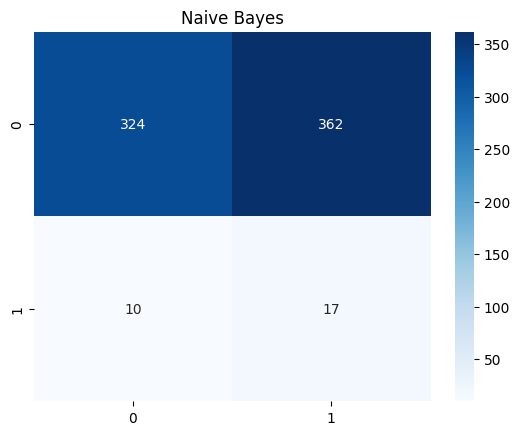

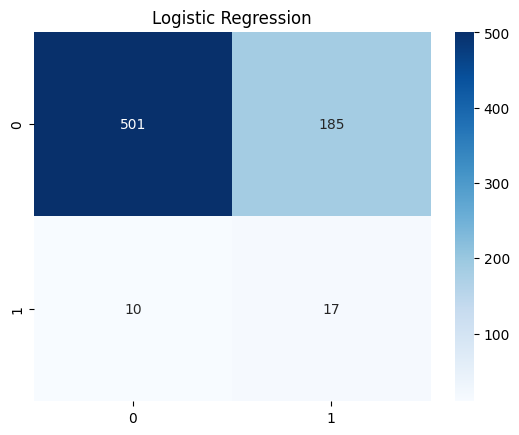

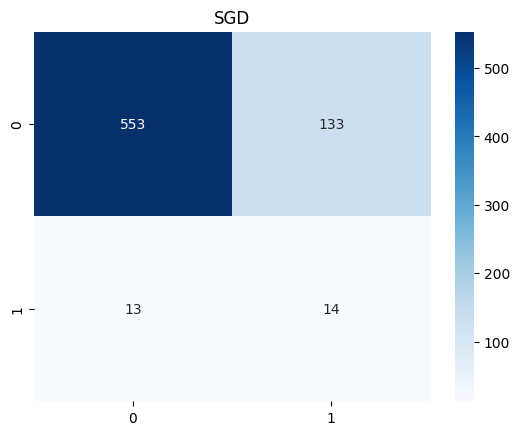

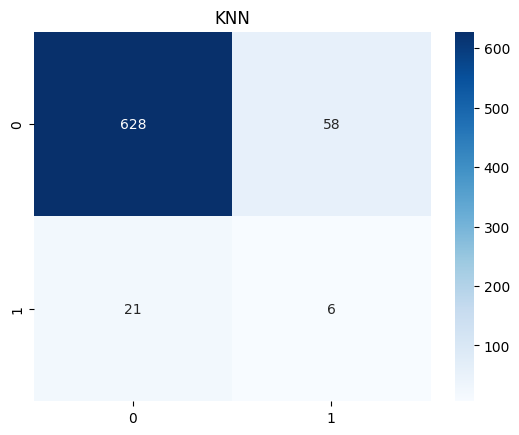

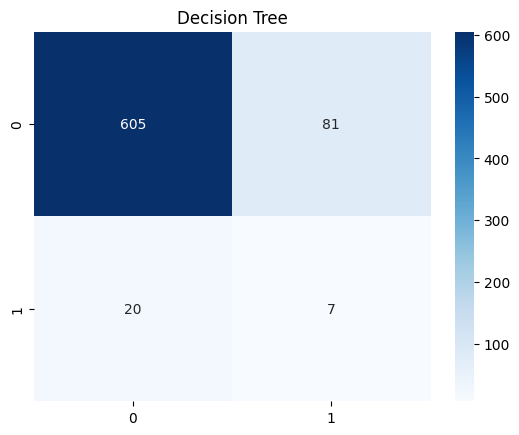

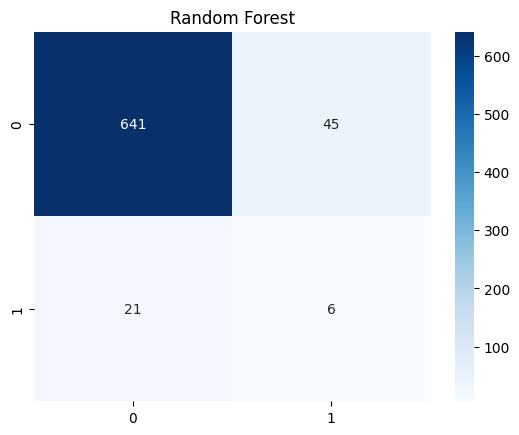

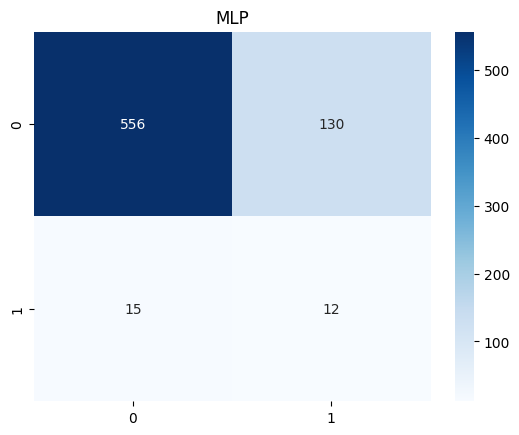

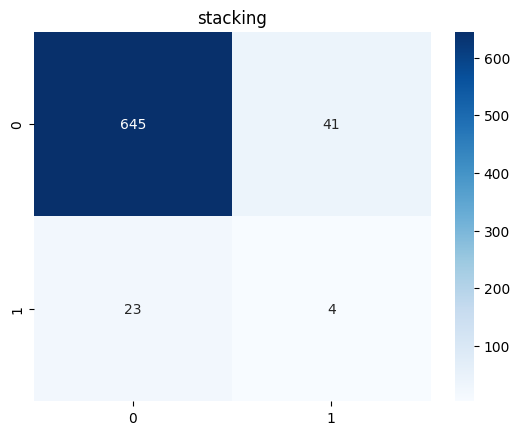

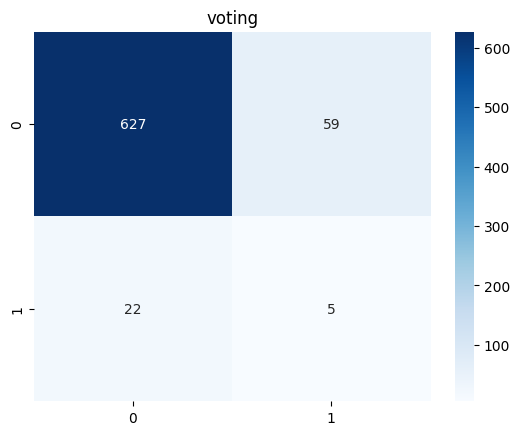

In [74]:
# Iterate through each model and its corresponding confusion matrix in the dictionary
for k, m in confusion_matrices.items():
    plt.figure()
    plt.title(k)
    sns.heatmap(m, annot=True, fmt='d', cmap='Blues') # Plot the confusion matrix as a heatmap with annotations

The confusion matrices below reveal that the models are not performing well. This issue arises because the dataset is imbalanced. Although we balanced the data for the training phase, the test data remains unbalanced. As a result, the models struggle to correctly predict stroke cases, leading to a high number of false negatives.

Text(0.5, 1.0, 'AUC')

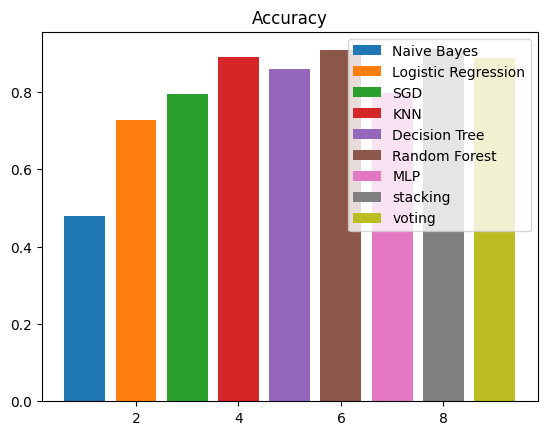

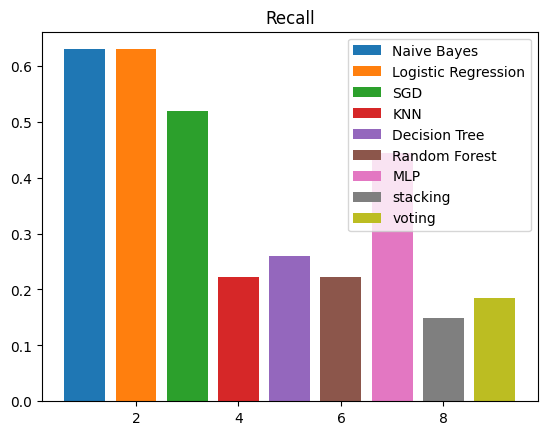

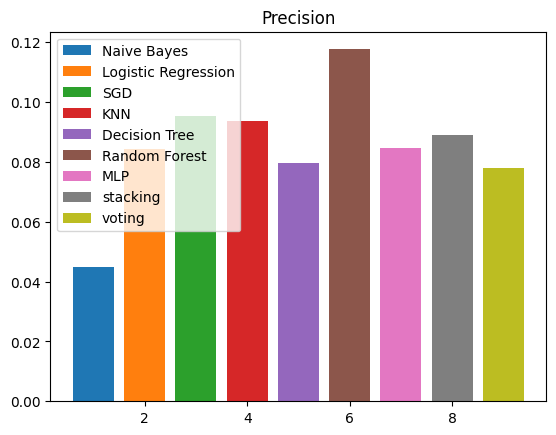

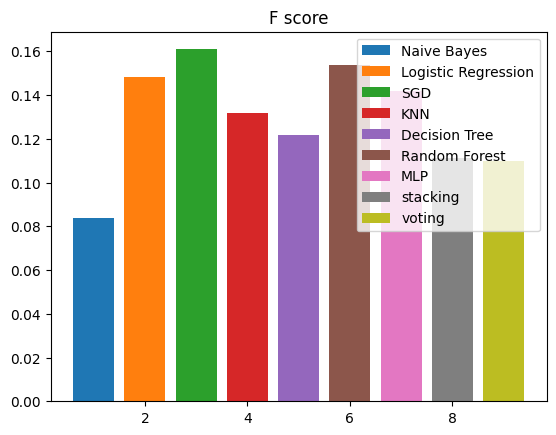

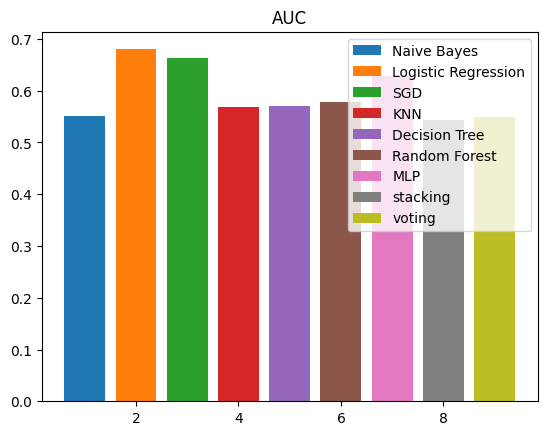

In [75]:
## Accuracy
plt.figure()
i=1
for k, v in accuracy.items():
    plt.bar(i, v, label = k)
    i+=1

plt.legend()
plt.title("Accuracy")

## Recall
plt.figure()
i=1
for k, v in recall.items():
    plt.bar(i, v, label = k)
    i+=1

plt.legend()
plt.title("Recall")

## Precision
plt.figure()
i=1
for k, v in precision.items():
    plt.bar(i, v, label = k)
    i+=1

plt.legend()
plt.title("Precision")

## F score
plt.figure()
i=1
for k, v in F_metric.items():
    plt.bar(i, v, label = k)
    i+=1

plt.legend()
plt.title("F score")

## AUC
plt.figure()
i=1
for k, v in auc_score.items():
    plt.bar(i, v, label = k)
    i+=1

plt.legend()
plt.title("AUC")

<Axes: >

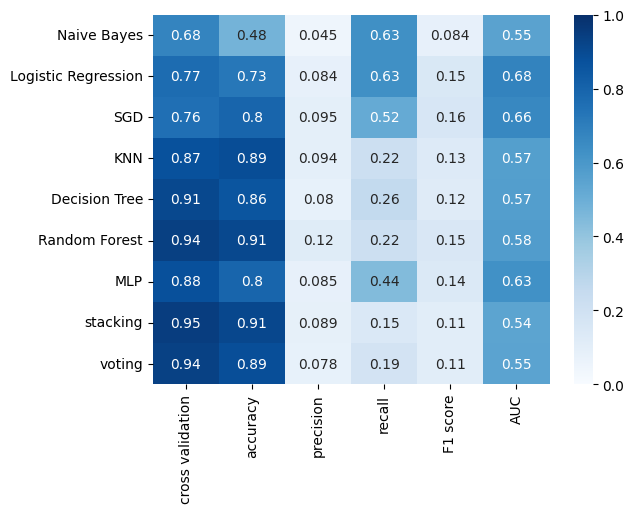

In [76]:
model_matrix = dict()

for k in models.keys():
    model_matrix[k] = list()
    model_matrix[k].append(cross_val_scores_mean[k])
    model_matrix[k].append(accuracy[k])
    model_matrix[k].append(precision[k])
    model_matrix[k].append(recall[k])
    model_matrix[k].append(F_metric[k])
    model_matrix[k].append(auc_score[k])


matrix = pd.DataFrame(model_matrix, index=['cross validation', 'accuracy', 'precision', 'recall', 'F1 score', 'AUC']).T

sns.heatmap(matrix, annot = True, vmin=0, vmax=1, cmap='Blues')